# MBA DSA USP/ESALQ 2024.1 Time 2
## Desafio House Prices

## A fazer:
- Modelo de regressão linear nos dados normalizados possui resultado explosivo. Indicações que pode ocorrer em função de outliers (o que não acontece em algoritmos tree-based, como xgboost, gradient boost, decision trees e random forests). Seguir verificando.
- Normalização Gelman (http://www.stat.columbia.edu/~gelman/research/published/standardizing7.pdf) - 1/(2*sd)

Primeiro aproach sem pré-processamento dos dados por ML. Em uma próxima abordagem pode ser realizado algum tipo de pré-processamento contido no TensorFlow ou Scikit-Learn.

# Processamento dos dados

## Carregamento dos dados

Importação das bibliotecas necessárias

In [1]:
import pandas as pd
import numpy as np

pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)
np.set_printoptions(suppress=True, precision=6)

Leitura dos dados amplos (arquivos de treino/teste) para unificação e tratamento por completo antes da modelagem.

In [2]:
treino = pd.read_csv("train.csv")
teste = pd.read_csv("test.csv")

# Ajuste das dimensões - inclusão da coluna SalePrice no dataset de teste
teste["SalePrice"] = 0

# Inclusão de informação sobre dataset de origem
teste["Origem"] = "Teste"
treino["Origem"] = "Treino"

dados_brutos = pd.concat([treino, teste])

print("Quantidade de linhas e colunas")
print(dados_brutos.shape)

Quantidade de linhas e colunas
(2919, 82)


## Análise das variáveis categóricas/de classificação

### Separação das variáveis entre categóricas e numéricas

In [3]:
coluna_origem = dados_brutos["Origem"]
#coluna_ids = dados_brutos["Id"]

colunas_quali = dados_brutos.columns[dados_brutos.dtypes == "object"]
variaveis_quanti = dados_brutos.drop(colunas_quali, axis = 1)

colunas_quanti = dados_brutos.columns[dados_brutos.dtypes != "object"]
variaveis_quali = dados_brutos.drop(colunas_quanti, axis = 1)

"""
#print("AS VARIÁVEIS NUMÉRICAS ('QUANTI') ENTÃO SÃO " + str(len(variaveis_quanti.columns)) + ":")
#print(variaveis_quanti.columns)
#print("\n")

#print("AS VARIÁVEIS NÃO-NÚMERICAS ('QUALI') FICAM SENDO APENAS " + str(len(variaveis_quali.columns)) + ":")
#print(variaveis_quali.columns)
#print("\n")

"""
#print("REINSERÇÃO DA COLUNA 'ORIGEM' PARA CONTROLE NAS VARIÁVEIS QUANTI E REFAZIMENTO DOS ÍNDICES:")
variaveis_quanti["Origem"] = coluna_origem
variaveis_quanti.reset_index(inplace=True)
variaveis_quali.reset_index(inplace=True)
variaveis_quanti = variaveis_quanti.drop("index", axis = 1)
variaveis_quanti = variaveis_quanti.drop("Id", axis = 1)
variaveis_quali = variaveis_quali.drop("index", axis = 1)

### Variáveis de Classificação

Algumas variáveis tem valores nulos, que serão imputados com classificações apropriadas. O processo de decisão sobre a imputação é tratado caso a caso.

In [4]:
nulos = variaveis_quali.isnull().sum()
nulos_ordenados = (nulos.sort_values(ascending=False)/len(variaveis_quali))*100

"""
print("Percentual de valores nulos por cada variável:")
print(nulos_ordenados.head(25))
print("\nComo os últimos valores já são zero, depois desses todos são zerados mesmo. Ou seja, não existem valores nulos nas outras variáveis")
"""

'\nprint("Percentual de valores nulos por cada variável:")\nprint(nulos_ordenados.head(25))\nprint("\nComo os últimos valores já são zero, depois desses todos são zerados mesmo. Ou seja, não existem valores nulos nas outras variáveis")\n'

Verificação das variáveis com maior falta de dados. Como tratam-se de variáveis de classificação, muitas vezes a imputação é simples e válida de ser feita.

In [5]:
"""
print("Variáveis com % significativo de falta de dados (acima de 20%):")
print(nulos_ordenados.head(5))
print("\nAs demais variáveis terão todos seus valores NaN imputados ou as observações NaN serão desconsideradas.")
"""

'\nprint("Variáveis com % significativo de falta de dados (acima de 20%):")\nprint(nulos_ordenados.head(5))\nprint("\nAs demais variáveis terão todos seus valores NaN imputados ou as observações NaN serão desconsideradas.")\n'

Descrição das variáveis com maior falta de dados: 
- PoolQC: valores NaN indicam inexistência de piscina (imputar 'None' então)
- MiscFeature: miscelânea, NaN indica inexistência desse tipo de feature (imputar 'None')
- Alley: tipo de viela/ruazinha para acesso à casa. Se a casa tem saída para a rua principal, a característica não tem nem como existir (imputar 'None')
- Fence: qualidade da cerca da casa, se a casa não possui cerca por obviedade essa informação é NaN (imputar 'None')
- FireplaceQu: indica existência de lareira na casa (imputar 'None')

In [6]:
imputar_none = ["PoolQC", "MiscFeature", "Alley", "Fence", "FireplaceQu"]
variaveis_quali[imputar_none] = variaveis_quali[imputar_none].fillna("None")

#### Demais variáveis

In [7]:
nulos = variaveis_quali.isnull().sum()
nulos_ordenados = nulos.sort_values(ascending=False)

temp = pd.DataFrame(nulos_ordenados)
mask = temp[0].isin([0])
print(temp[~mask].index)

Index(['GarageCond', 'GarageQual', 'GarageFinish', 'GarageType', 'BsmtCond',
       'BsmtExposure', 'BsmtQual', 'BsmtFinType2', 'BsmtFinType1',
       'MasVnrType', 'MSZoning', 'Functional', 'Utilities', 'KitchenQual',
       'SaleType', 'Exterior1st', 'Exterior2nd', 'Electrical'],
      dtype='object')


Imputação de 'None' diretamente:
- "Garage"XYZ: as variáveis "Garage"XYZ classificam o estado de conservação, acabamento e localização da garagem, se existente. NaN indica inexistência de garagem (imputa 'None').
- "Bsmt"XYZ: as variáveis "Bsmt"XYZ classificam o nível de qualidade, exposição e acabamentos do porão, se existente. NaN indica inexistência de porão (imputa 'None').
- Exterior1st: Exterior covering on house. Deduzo que NaN indique inexistência, imputa 'None'.
- Exterior2nd: Exterior covering on house (if more than one material) (deve ter correlação direta com o acima).
- MasVnrType: Masonry veneer type. Descrição contempla opção de 'None', assume-se que informação inexistente corresponda a 'None'.

In [8]:
imputar_none2 = ['GarageCond', 'GarageQual', 'GarageFinish', 'GarageType', 'BsmtCond', 'BsmtExposure', 'BsmtQual', 'BsmtFinType2', 'BsmtFinType1','Exterior1st', 'Exterior2nd', 'MasVnrType']
variaveis_quali[imputar_none2] = variaveis_quali[imputar_none2].fillna("None")

Imputação arbitrada para a classificação:
- Functional: Home functionality (Assume typical unless deductions are warranted). NaN imputado "Typ".
- SaleType: tipo de venda, imputado moda de "OverallCond" (banco de dados original).
- Utilities: tipos de serviços básicos disponíveis (água, luz, gás, etc.). Imputada moda da vizinhança.
- KitchenQual: qualidade da cozinha. Imputada moda da vizinhança.
- Electrical: Electrical system. Imputada moda da vizinhança.
- MSZoning: Identifies the general zoning classification of the sale. Como se trata de zoneamento, assume-se que em um mesmo bairro o zoneamento seja o mesmo(sem NaN na descrição).

In [9]:
# Variaveis imputadas com moda da região (vizinhança)

variaveis_quali["Functional"] = variaveis_quali["Functional"].fillna("Typ")
variaveis_quali["Utilities"] = variaveis_quali["Utilities"].fillna("AllPub")
variaveis_quali["SaleType"] = variaveis_quali["SaleType"].fillna("WD")
variaveis_quali["MSZoning"].loc[2904] = "RL" # específico para essa observação o bairro é diferente, com outra moda
variaveis_quali["MSZoning"] = variaveis_quali["MSZoning"].fillna("RM")


# Processo da imputação ("KitchenQual", nessa explicação)
# Primeiro vê qual observação é NaN, extraindo a informação sobre vizinhança
kitchen_neigh = variaveis_quali[variaveis_quali["KitchenQual"].isnull()][["Neighborhood"]]
# Com a informação sobre a vizinhança, verifica a moda da vizinhança para a variável com NaN
kitchen_qual = variaveis_quali[variaveis_quali["Neighborhood"] == kitchen_neigh.iloc[0,0]][["KitchenQual"]].mode()
# Por último, imputa a moda da vizinhança para a informação faltante
variaveis_quali["KitchenQual"] = variaveis_quali["KitchenQual"].fillna(kitchen_qual.iloc[0,0])


# Repete o processo acima, para a variável "Electrical"
elec_neigh = variaveis_quali[variaveis_quali["Electrical"].isnull()][["Neighborhood"]]
elec_qual = variaveis_quali[variaveis_quali["Neighborhood"] == elec_neigh.iloc[0,0]][["Electrical"]].mode()
variaveis_quali["Electrical"] = variaveis_quali["Electrical"].fillna(elec_qual.iloc[0,0])

### Variáveis Numéricas

In [10]:
"""
nulos_quanti = variaveis_quanti.isnull().sum()
nulos_ordenados_quanti = (nulos_quanti.sort_values(ascending=False)/len(variaveis_quanti))*100

print("Percentual de valores nulos por cada variável:")
print(nulos_ordenados_quanti.head(12))
print("\nComo os últimos valores já são zero, depois desses todos são zerados mesmo. Ou seja, não existem valores nulos nas outras variáveis")
"""

'\nnulos_quanti = variaveis_quanti.isnull().sum()\nnulos_ordenados_quanti = (nulos_quanti.sort_values(ascending=False)/len(variaveis_quanti))*100\n\nprint("Percentual de valores nulos por cada variável:")\nprint(nulos_ordenados_quanti.head(12))\nprint("\nComo os últimos valores já são zero, depois desses todos são zerados mesmo. Ou seja, não existem valores nulos nas outras variáveis")\n'

Variáveis ajustadas:
- GarageArea - tamanho da garagem, utilizada a mediana das garagens com mesmo GarageType.
- GarageYrBlt - Ano em que a garagem foi construída. Se existe uma garagem construída após a última reforma (GarageYrBlt > YearRemodAdd), é estabelecido que esse ano maior seja o ano da última reforma. A variável GarageYrBlt é utilizada para a contabilização da idade da casa (quanto menor, melhor; reflete positivamente no preço).
- LotFrontage - Dimensão da frente do terreno, em pés. Calculada a partir da divisão da LotArea pela média da divisão LotArea/LotFrontage dos valores pré-existentes.
- MasVnrArea - Masonry veneer area in square feet. Relação direta com a MasVnrType (variável qualitativa) - se esta é inexistente (como todas NaN aqui são), então a área é 0.
- GarageCars - tamanho da garagem em questão de capacidade de números de carros, utilizada média das demais garagens em função da área da garagem.
- BsmtHalfBath - valores NaN pois não existem porões, imputado zero.

In [11]:

# Imputação variável "GarageArea"
#variaveis_quanti["GarageArea"].isnull().sum() # a variável GarageArea possui apenas um valor nulo
#variaveis_quanti["GarageArea"][variaveis_quanti["GarageArea"].isnull()] # informa que é a observação 1116
#dados_brutos["GarageArea"].loc[1116] # como são dois datasets reunidos, temos duas observações '1116', mas apenas uma NaN
#dados_brutos["GarageType"].loc[1116] # o tipo da garagem em questão é "Detchd", então será imputada a mediana do tamanho das garagens desse tipo
fill_garagearea = dados_brutos[dados_brutos["GarageType"] == "Detchd"][["GarageArea"]].median() # calcula a mediana das garagens do referido tipo
variaveis_quanti["GarageArea"] = variaveis_quanti["GarageArea"].fillna(fill_garagearea[0]) # imputa o valor

# Uma garagem possui erro de registro, possuindo GarageYrBlt como '2207', seguro assumir que o correto seja '2007' - o ano de reforma
variaveis_quanti.loc[2592, "GarageYrBlt"] = variaveis_quanti.loc[2592, "YearRemodAdd"]

# Algumas garagens possuem ano de construção anterior ao ano da casa. Assumindo o menor entre os dois anos como a construção da casa.
ajuste_ano = variaveis_quanti[variaveis_quanti["YearBuilt"] > variaveis_quanti["GarageYrBlt"]]
variaveis_quanti["YearBuilt"].loc[ajuste_ano.index[:]] = variaveis_quanti["GarageYrBlt"].loc[ajuste_ano.index[:]]

# Duas observações possuem YrSold < YearRemodAdd, assume-se que o ano de venda seja, no mínimo, o ano da reforma.
variaveis_quanti.loc[523, "YrSold"] = variaveis_quanti.loc[523, "YearRemodAdd"]
variaveis_quanti.loc[2295, "YrSold"] = variaveis_quanti.loc[2295, "YearRemodAdd"]

# A observação 2549 tem como registro YrSold < YearBuilt|YearRemodAdd, imputando o maior valor entre os três para YrSold:
variaveis_quanti.loc[2549, "YrSold"] = variaveis_quanti.loc[2549, "YearRemodAdd"]

# Algumas garagens não possuem ano de construção, porém possuem área (logo, existem). Seguro assumir que foi feita junto com a casa.
filtro = variaveis_quanti[variaveis_quanti["GarageYrBlt"].isnull()].index.isin(variaveis_quali[variaveis_quali["GarageType"] == "None"].index) == False
garagem_semano = variaveis_quanti[variaveis_quanti["GarageYrBlt"].isnull()][filtro] # registra quais Id's não possuem GarageYrBlt

for i in garagem_semano.index:
    if pd.isna(variaveis_quanti.loc[i, "GarageYrBlt"]):
        variaveis_quanti.loc[i, "GarageYrBlt"] = variaveis_quanti.loc[i, "YearBuilt"]

# Neste ponto todas as garagens existentes possuem anos correspondentes. De resto, é imputado '0' à GarageYrBlt para feature engeneering.
variaveis_quanti[variaveis_quanti["GarageYrBlt"].isnull()] = variaveis_quanti[variaveis_quanti["GarageYrBlt"].isnull()].fillna(0)

# A variável GarageYrBlt é utilizada para a contabilização da idade da casa (quanto menor, melhor; reflete diretamente no preço)
# Se existe uma garagem construída após a última reforma (GarageYrBlt > YearRemodAdd), é estabelecido que esse ano maior seja o ano da última reforma
garagem_reforma = variaveis_quanti[variaveis_quanti["GarageYrBlt"] > variaveis_quanti["YearRemodAdd"]].index
for i in garagem_reforma:
    if (variaveis_quanti.loc[i, "GarageYrBlt"] > variaveis_quanti.loc[i, "YearRemodAdd"]):
        variaveis_quanti.loc[i, "YearRemodAdd"] = variaveis_quanti.loc[i, "GarageYrBlt"]

# MasVnrArea com NaN são todas observações em que MasVnrType é igual a "None", então, inexistente, logo, área igual a zero
variaveis_quanti[variaveis_quanti["MasVnrArea"].isnull()] = variaveis_quanti[variaveis_quanti["MasVnrArea"].isnull()].fillna(0)

# Cria um índice das garagens com área maior que zero (para não incorrer em erro posterior)
ind = variaveis_quanti[variaveis_quanti["GarageArea"] > 0].index
garagem_por_carro = variaveis_quanti["GarageCars"][ind]/variaveis_quanti["GarageArea"][ind]
vagas = variaveis_quanti[variaveis_quanti["GarageCars"].isnull()].index #apenas uma garagem possui área e não possui registro de quantidade de vagas
vaga_faltante = variaveis_quanti[variaveis_quanti["GarageCars"].isnull()]["GarageArea"] * garagem_por_carro.mean() # obtenção do valor referente à quantidade de vagas da garagem
variaveis_quanti["GarageCars"][vagas] = vaga_faltante # imputação do valor

# BsmtHalfBath, valores NaN pois não existem porões, imputado zero.
variaveis_quanti[variaveis_quanti["BsmtHalfBath"].isnull()] = variaveis_quanti[variaveis_quanti["BsmtHalfBath"].isnull()].fillna(0)


# Imputação das observaçẽos LotFrontage
frontage = variaveis_quanti["LotFrontage"].sum()/len(variaveis_quanti[variaveis_quanti["LotFrontage"] > 0])

# Cria um DataFrame com as frentes estimadas (de todas observações)
frente_estimada_geral = pd.DataFrame(variaveis_quanti["LotArea"]/frontage)

# Preenchendo os NaN de LotFrontage com zeros
filtro = variaveis_quanti["LotFrontage"].isnull()
variaveis_quanti["LotFrontage"][filtro] = 0

# Separa-se apenas as observações LotFrontage a preencher (valores zerados)
sem_frente = variaveis_quanti[variaveis_quanti["LotFrontage"] == 0].index
for i in sem_frente:
    variaveis_quanti.loc[i, "LotFrontage"] = frente_estimada_geral.loc[i, "LotArea"]

/tmp/ipykernel_145924/2072175058.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  variaveis_quanti["YearBuilt"].loc[ajuste_ano.index[:]] = variaveis_quanti["GarageYrBlt"].loc[ajuste_ano.index[:]]
/tmp/ipykernel_145924/2072175058.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  variaveis_quanti["GarageCars"][vagas] = vaga_faltante # imputação do valor
/tmp/ipykernel_145924/2072175058.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a

## Feature Engeneering

    Idade do Imóvel (no momento da venda)
Adicionada uma variável quantitativa referente à idade da casa no ano registrado de venda, levado em consideração eventual reforma existente no ínterim.

In [12]:
# Atribução de uma nova variável "IdadeCasa", correspondente ao ano de fabricação menos o ano de venda, abatendo também anos em função de reforma

ganho_reforma = 0.3 # aqui o ganho é inverso: '0' indica 100% de ganho, '1' indica 0% de ganho em reforma
casa_reformada = (variaveis_quanti["YearRemodAdd"] - variaveis_quanti["YearBuilt"]) * (1 - ganho_reforma)
idade_casa = variaveis_quanti["YrSold"] - variaveis_quanti["YearBuilt"] - casa_reformada
variaveis_quanti["IdadeCasa"] = idade_casa

    MoSold (mês de venda)
Esta é uma variável categórica que foi enquadrada como numérica. Revertendo.

In [13]:
variaveis_quali["MoSold"] = variaveis_quanti["MoSold"]
variaveis_quali["MoSold"] = variaveis_quali["MoSold"].astype(object)
variaveis_quanti = variaveis_quanti.drop("MoSold", axis = 1)

    MSSubClass
Esta é uma variável categórica que foi enquadrada como numérica. Revertendo.

In [14]:
variaveis_quali["MSSubClass"] = variaveis_quanti["MSSubClass"]
variaveis_quali["MSSubClass"] = variaveis_quali["MSSubClass"].astype(object)
variaveis_quanti = variaveis_quanti.drop("MSSubClass", axis = 1)

    YrSold (ano de venda)
Foi usada para definir a idade da casa anteriormente. A variável possui uma amplitide de apenas 4 anos (2006-2010), como a idade já está estabelecida agora transforma-se essa variável em categórica (crise de 2008 deve impactar).

In [15]:
variaveis_quali["YrSold"] = variaveis_quanti["YrSold"]
variaveis_quali["YrSold"] = variaveis_quali["YrSold"].astype(object)
variaveis_quanti = variaveis_quanti.drop("YrSold", axis = 1)

    Porão
TotalBsmtSF é a soma das outras três variáveis, "BsmtFinSF1", "BsmtFinSF2" e "BsmtUnfSF".

Criação da variável "PoraoUtil", contabilizando apenas a área finalizada (útil) do porão, descartando-se as demais medidas de área do porão.

In [16]:
porao_util = variaveis_quanti["TotalBsmtSF"] - variaveis_quanti["BsmtUnfSF"]
variaveis_quanti["PoraoUtil"] = porao_util
variaveis_quanti = variaveis_quanti.drop("BsmtFinSF1", axis = 1)
variaveis_quanti = variaveis_quanti.drop("BsmtFinSF2", axis = 1)
variaveis_quanti = variaveis_quanti.drop("BsmtUnfSF", axis = 1)
variaveis_quanti = variaveis_quanti.drop("TotalBsmtSF", axis = 1)

	Area Construída (total)

- GrLivArea: 1stFlrSF + 2ndFlrSF + LowQualFinSF

Variáveis criadas:
- AndaresProntos = 1stFlrSF + 2ndFlrSF (informa apenas a parte propriamente habitável dos andares)
- TerrenoLivre = LotArea - 1stFlrSF (área total do terreno menos a área da casa, desconsiderando-se áreas de lazer - piscina, deck ou varanda)
- AreaCasaTotal = AndaresProntos + porão pronto

In [17]:
andares_prontos = variaveis_quanti["2ndFlrSF"] + variaveis_quanti["1stFlrSF"]
area_livre_terreno = variaveis_quanti["LotArea"] - variaveis_quanti["1stFlrSF"]
area_casa_total = andares_prontos + porao_util
variaveis_quanti["AndaresProntos"] = andares_prontos
variaveis_quanti["TerrenoLivre"] = area_livre_terreno
variaveis_quanti["AreaCasaTotal"] = area_casa_total

    Área de Lazer
Criada uma nova variável contemplando o total da área de lazer disponível, somando-se as áreas das variáveis "WoodDeckSF", "OpenPorchSF", "EnclosedPorch", 
"3SsnPorch", "ScreenPorch" e "PoolArea".

In [18]:
variaveis_quanti["AreaLazerTotal"] =  variaveis_quanti["WoodDeckSF"] + variaveis_quanti["OpenPorchSF"] + \
                                    variaveis_quanti["EnclosedPorch"] + variaveis_quanti["3SsnPorch"] + \
                                    variaveis_quanti["ScreenPorch"] + variaveis_quanti["PoolArea"]

Criação das variaveis deck, varanda e piscina

In [19]:
# Deck
deck = {"foo"}
deck = pd.DataFrame(deck)

for i in variaveis_quanti["WoodDeckSF"]:
    if i == 0: deck.loc[len(deck)] = "None"
    else: deck.loc[len(deck)] = "Yes"

deck = deck.iloc[1:]
deck.reset_index(inplace=True)
deck = deck.drop("index", axis = 1)

# Varanda
porch = variaveis_quanti["OpenPorchSF"] + variaveis_quanti["EnclosedPorch"] + variaveis_quanti["3SsnPorch"] + variaveis_quanti["ScreenPorch"]
varanda = {"foo"}
varanda = pd.DataFrame(varanda)

for i in porch:
    if i == 0: varanda.loc[len(varanda)] = "None"
    else: varanda.loc[len(varanda)] = "Yes"

varanda = varanda.iloc[1:]
varanda.reset_index(inplace=True)
varanda = varanda.drop("index", axis = 1)

# Piscina
piscina = {"foo"}
piscina = pd.DataFrame(piscina)

for i in variaveis_quanti["PoolArea"]:
    if i == 0: piscina.loc[len(piscina)] = "None"
    else: piscina.loc[len(piscina)] = "Yes"

piscina = piscina.iloc[1:]
piscina.reset_index(inplace=True)
piscina = piscina.drop("index", axis = 1)

Atribuição das áreas de lazer independentes como categorias, eliminando as variáveis numéricas originais. Mantive apenas a variável PoolArea, pois piscinas maiores ou menores impactam significativamente na estrutura de custos da casa, sendo descontado no valor.

In [20]:
variaveis_quali["Piscina"] = piscina
variaveis_quali["Varanda"] = varanda
variaveis_quali["Deck"] = deck
variaveis_quanti = variaveis_quanti.drop("WoodDeckSF", axis = 1)
variaveis_quanti = variaveis_quanti.drop("OpenPorchSF", axis = 1)
variaveis_quanti = variaveis_quanti.drop("EnclosedPorch", axis = 1)
variaveis_quanti = variaveis_quanti.drop("3SsnPorch", axis = 1)
variaveis_quanti = variaveis_quanti.drop("ScreenPorch", axis = 1)

    Banheiros
Divisão entre total dos banheiros da casa e total dos banheiros do porão.

In [21]:
banheiros_casa = variaveis_quanti["FullBath"] + variaveis_quanti["HalfBath"]
banheiros_porao = variaveis_quanti["BsmtFullBath"] + variaveis_quanti["BsmtHalfBath"]
variaveis_quanti["BanheirosCasa"] = banheiros_casa
variaveis_quanti["BanheirosPorao"] = banheiros_porao
variaveis_quanti = variaveis_quanti.drop("BsmtFullBath", axis = 1)
variaveis_quanti = variaveis_quanti.drop("BsmtHalfBath", axis = 1)
variaveis_quanti = variaveis_quanti.drop("FullBath", axis = 1)
variaveis_quanti = variaveis_quanti.drop("HalfBath", axis = 1)

    Demais variáveis já utilizadas, descarte

Algumas variáveis foram utilizadas para a criação de outras características e acabaram não sendo desconsideradas no momento oportuno. Realizando a filtragem desses dados abaixo.

In [22]:
variaveis_quanti = variaveis_quanti.drop("YearBuilt", axis = 1)
variaveis_quanti = variaveis_quanti.drop("YearRemodAdd", axis = 1)
variaveis_quanti = variaveis_quanti.drop("1stFlrSF", axis = 1)
variaveis_quanti = variaveis_quanti.drop("2ndFlrSF", axis = 1)
variaveis_quanti = variaveis_quanti.drop("LowQualFinSF", axis = 1)
variaveis_quanti = variaveis_quanti.drop("GarageYrBlt", axis = 1)

    Outliers
Verificação de algumas variáveis numéricas com possível existência de outliers.

A primeira que saltou aos olhos foi a variável "LotFrontage", testando trabalhar sem as observações contendo os outliers desta variável, através de método IQR

In [23]:
#variaveis_outliers = variaveis_quanti[["LotFrontage", "LotArea", "PoraoUtil", "TerrenoLivre", "AreaCasaTotal", "AreaLazerTotal"]]

variaveis_quanti_teste = variaveis_quanti.copy()
variaveis_quali_backup = variaveis_quali.copy()

###
# Outliers variável "LotFrontage"
###
q1_lotfrontage = np.percentile(variaveis_quanti["LotFrontage"], 25)
q3_lotfrontage = np.percentile(variaveis_quanti["LotFrontage"], 75)
iqr_lotfrontage = q3_lotfrontage - q1_lotfrontage
outliers_lotfrontage_up = q3_lotfrontage + 1.5 * iqr_lotfrontage
outliers_lotfrontage_low = q1_lotfrontage - 1.5 * iqr_lotfrontage

apagar = variaveis_quanti[variaveis_quanti["LotFrontage"] >= outliers_lotfrontage_up].index
variaveis_quanti = variaveis_quanti.drop(apagar, axis = 0)
variaveis_quali = variaveis_quali.drop(apagar, axis = 0)
variaveis_quanti.reset_index(inplace = True)
variaveis_quali.reset_index(inplace = True)
variaveis_quanti = variaveis_quanti.drop("index", axis = 1)
variaveis_quali = variaveis_quali.drop("index", axis = 1)


###
# Outliers variável "TerrenoLivre" - com este e o "LotArea" os dados acabam ficando com bem menos outliers no geral.
###
q1_terrenolivre = np.percentile(variaveis_quanti["TerrenoLivre"], 25)
q3_terrenolivre = np.percentile(variaveis_quanti["TerrenoLivre"], 75)
iqr_terrenolivre = q3_terrenolivre - q1_terrenolivre
outliers_terrenolivre_up = q3_terrenolivre + 1.5 * iqr_terrenolivre
outliers_terrenolivre_low = q1_terrenolivre - 1.5 * iqr_terrenolivre

apagar_terrenolivre_up = variaveis_quanti[variaveis_quanti["TerrenoLivre"] >= outliers_terrenolivre_up].index
variaveis_quanti = variaveis_quanti.drop(apagar_terrenolivre_up, axis = 0)
variaveis_quali = variaveis_quali.drop(apagar_terrenolivre_up, axis = 0)

apagar_terrenolivre_low = variaveis_quanti[variaveis_quanti["TerrenoLivre"] <= outliers_terrenolivre_low].index
variaveis_quanti = variaveis_quanti.drop(apagar_terrenolivre_low, axis = 0)
variaveis_quali = variaveis_quali.drop(apagar_terrenolivre_low, axis = 0)

variaveis_quali.reset_index(inplace = True)
variaveis_quanti.reset_index(inplace = True)
variaveis_quanti = variaveis_quanti.drop("index", axis = 1)
variaveis_quali = variaveis_quali.drop("index", axis = 1)


"""
###
# Outliers variável "LotArea"
###
q1_lotarea = np.percentile(variaveis_quanti["LotArea"], 25)
q3_lotarea = np.percentile(variaveis_quanti["LotArea"], 75)
iqr_lotarea = q3_lotarea - q1_lotarea
outliers_lotarea_up = q3_lotarea + 1.5 * iqr_lotarea
outliers_lotarea_low = q1_lotarea - 1.5 * iqr_lotarea

apagar_lotarea_up = variaveis_quanti[variaveis_quanti["LotArea"] >= outliers_lotarea_up].index
variaveis_quanti = variaveis_quanti.drop(apagar_lotarea_up, axis = 0)
variaveis_quali = variaveis_quali.drop(apagar_lotarea_up, axis = 0)

apagar_lotarea_low = variaveis_quanti[variaveis_quanti["LotArea"] <= outliers_lotarea_low].index
variaveis_quanti = variaveis_quanti.drop(apagar_lotarea_low, axis = 0)
variaveis_quanti.reset_index(inplace = True)
variaveis_quali = variaveis_quali.drop(apagar_lotarea_low, axis = 0)
variaveis_quali.reset_index(inplace = True)
variaveis_quanti = variaveis_quanti.drop("index", axis = 1)
variaveis_quali = variaveis_quali.drop("index", axis = 1)
"""

'\n###\n# Outliers variável "LotArea"\n###\nq1_lotarea = np.percentile(variaveis_quanti["LotArea"], 25)\nq3_lotarea = np.percentile(variaveis_quanti["LotArea"], 75)\niqr_lotarea = q3_lotarea - q1_lotarea\noutliers_lotarea_up = q3_lotarea + 1.5 * iqr_lotarea\noutliers_lotarea_low = q1_lotarea - 1.5 * iqr_lotarea\n\napagar_lotarea_up = variaveis_quanti[variaveis_quanti["LotArea"] >= outliers_lotarea_up].index\nvariaveis_quanti = variaveis_quanti.drop(apagar_lotarea_up, axis = 0)\nvariaveis_quali = variaveis_quali.drop(apagar_lotarea_up, axis = 0)\n\napagar_lotarea_low = variaveis_quanti[variaveis_quanti["LotArea"] <= outliers_lotarea_low].index\nvariaveis_quanti = variaveis_quanti.drop(apagar_lotarea_low, axis = 0)\nvariaveis_quanti.reset_index(inplace = True)\nvariaveis_quali = variaveis_quali.drop(apagar_lotarea_low, axis = 0)\nvariaveis_quali.reset_index(inplace = True)\nvariaveis_quanti = variaveis_quanti.drop("index", axis = 1)\nvariaveis_quali = variaveis_quali.drop("index", axis =

## Modelagem

### Bibliotecas necessárias

In [24]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler # normalização por z-score
from sklearn.preprocessing import FunctionTransformer # normalização por log
from sklearn.preprocessing import MinMaxScaler # normalização Min-Max

from sklearn.model_selection import train_test_split # separação de grupo treino e teste
from sklearn import tree # biblioteca para modelagem através de decision tree (árvore de decisão)
from sklearn.neighbors import KNeighborsRegressor # biblioteca para modelagem através de KNN
from sklearn.ensemble import GradientBoostingRegressor # biblioteca para modelagem com Gradient Boost
from sklearn.linear_model import LinearRegression # biblioteca para modelagem através de regressão Linear Simples
from sklearn.linear_model import Ridge # biblioteca para modelagem com Ridge
from sklearn import linear_model # biblioteca para modelagem com Bayesian Ridge

#### Documentação

Linear Regression (Regressão Linear)
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression

Decision Tree (Árvore de Decisão)
https://scikit-learn.org/stable/modules/tree.html#regression

KNN - K Nearest Neighbors (Vizinhança Próxima)
https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html

Gradient Boost Regressor
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html#sklearn.ensemble.GradientBoostingRegressor

Ridge
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html#sklearn.linear_model.Ridge

Bayesian Ridge Regression
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.BayesianRidge.html#sklearn.linear_model.BayesianRidge

### Separação entre treino e teste, dummies

In [25]:
# GERANDO DUMMIES DAS VARIAVEIS QUALI
variaveis_quali_sem_dummies = variaveis_quali.copy()
quali_dummies = variaveis_quali_sem_dummies.drop("Origem", axis = 1)
quali_dummies = pd.get_dummies(quali_dummies)

# Armazenando os dados processados antes da modelagem
dummies_aqui = quali_dummies.copy()
quanti_sem_dummies = variaveis_quanti.copy()
quanti_com_dummies = pd.concat([quanti_sem_dummies, dummies_aqui], axis = "columns")
quanti_com_dummies_backup = quanti_com_dummies.copy()

# SEPARAÇÃO ENTRE TREINO E TESTE
dados_polidos = variaveis_quanti[variaveis_quanti["Origem"] == "Treino"]
dados_polidos = dados_polidos.drop("Origem", axis = 1)

dados_teste = variaveis_quanti_teste[variaveis_quanti_teste["Origem"] == "Teste"]
dados_teste = dados_teste.drop("Origem", axis = 1)
dados_teste = dados_teste.drop("SalePrice", axis = 1)

# Definição das variáveis independente e dependente
dados_polidos_x = dados_polidos.drop("SalePrice", axis = 1)
dados_polidos_y = dados_polidos.SalePrice

# Separação entre observações para treino e teste
treino_x, teste_x, treino_y, teste_y = train_test_split(dados_polidos_x, dados_polidos_y, test_size = 0.2, random_state = 1)

treino_x.reset_index(inplace=True)
treino_x = treino_x.drop("index", axis = 1)
teste_x.reset_index(inplace=True)
teste_x = teste_x.drop("index", axis = 1)

# Índices de coleta das observações separadss (teste/treino) para a correta inserções das respectivas dummies
treino_x_dummies = quali_dummies.iloc[treino_x.index]
treino_x_dummies.reset_index(inplace=True)
treino_x_dummies = treino_x_dummies.drop("index", axis = 1)

teste_x_dummies = quali_dummies.iloc[teste_x.index]
teste_x_dummies.reset_index(inplace=True)
teste_x_dummies = teste_x_dummies.drop("index", axis = 1)


/tmp/ipykernel_145924/3166758211.py:4: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  quali_dummies = pd.get_dummies(quali_dummies)
/tmp/ipykernel_145924/3166758211.py:4: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  quali_dummies = pd.get_dummies(quali_dummies)
/tmp/ipykernel_145924/3166758211.py:4: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  quali_dummies = pd.get_dummies(quali_dummies)


### Modelagem sem normalização

In [40]:
# Incluindo as dummies (não-normalizadas)
x_sn = pd.concat([pd.DataFrame(treino_x), treino_x_dummies], axis="columns")
x_sn.columns = range(len(x_sn.columns))

x_teste_sn = pd.concat([pd.DataFrame(teste_x), teste_x_dummies], axis="columns")
x_teste_sn.columns = range(len(x_teste_sn.columns))

###
# Estimação dos modelos
###

# Regressão Linear Simples (Linear Regression)
sn_rl = LinearRegression().fit(x_sn, treino_y)
y_rl = sn_rl.predict(x_teste_sn)

# Árvore de Decisão (decision tree)
sn_tree = tree.DecisionTreeRegressor(random_state = 1).fit(x_sn, treino_y)
y_tree = sn_tree.predict(x_teste_sn)

# (K Vizinhos Mais Próximos - KNN (K Nearest Neighbors))
sn_knn = KNeighborsRegressor(n_neighbors = 2, weights = "uniform").fit(x_sn, treino_y)
y_knn_uniform = sn_knn.predict(x_teste_sn)

sn_knn_d = KNeighborsRegressor(n_neighbors = 2, weights = "distance").fit(x_sn, treino_y)
y_knn_distance = sn_knn_d.predict(x_teste_sn)

# Gradient Boost Regressor
sn_gbr = GradientBoostingRegressor(random_state = 1).fit(x_sn, treino_y)
y_gbr = sn_gbr.predict(x_teste_sn)

# Ridge
sn_ridge = Ridge(alpha = 1.0).fit(x_sn, treino_y)
y_ridge = sn_ridge.predict(x_teste_sn)

# Bayesian Ridge Regression
sn_brr = linear_model.BayesianRidge().fit(x_sn, treino_y)
y_brr = sn_brr.predict(x_teste_sn)

    Sobre Normalização
Será utilizado apenas um método de normalização para todas as variáveis que serão utilizadas na modelagem de ML, uma vez que vários algoritmos de ML podem ter dificuldades em interpretar valores com escalas (normalizações) diferentes. Serão realizados testes com três metodologias de normalização diferentes, a saber:
- Min-max
- Z-score
- Log

Informações disponíveis em https://www.turing.com/kb/data-normalization-with-python-scikit-learn-tips-tricks-for-data-science

#### Exemplos:

    MiscVal
Valores de coisas diversas que acompanham a casa. Como os valores são assimétricos (cauda à esquerda), é necessário passar por normalização.

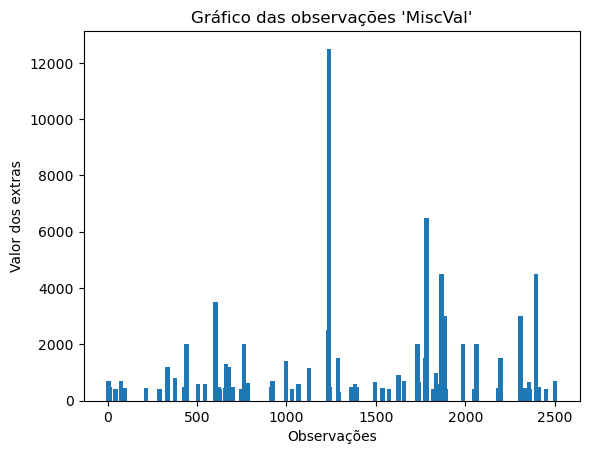

count       76.000000
mean      1162.776316
std       1723.077399
min         54.000000
25%        415.000000
50%        550.000000
75%       1200.000000
max      12500.000000
Name: MiscVal, dtype: float64


In [27]:
valores_miscval = variaveis_quanti[variaveis_quanti["MiscVal"] > 0]["MiscVal"]
#valores_miscval = valores_miscval.sort_values() # basta descomentar essa linha para gráfico com valores assimétricos
indice = variaveis_quanti[variaveis_quanti["MiscVal"] > 0]["MiscVal"].index 
                           
plt.title("Gráfico das observações 'MiscVal'")
plt.xlabel("Observações")
plt.ylabel("Valor dos extras")
plt.bar(indice, valores_miscval, width = 25)
plt.show()

print(variaveis_quanti[variaveis_quanti["MiscVal"] > 0]["MiscVal"].describe())

    SellPrice
Valores de venda, assimétricos. Necessário normalização.

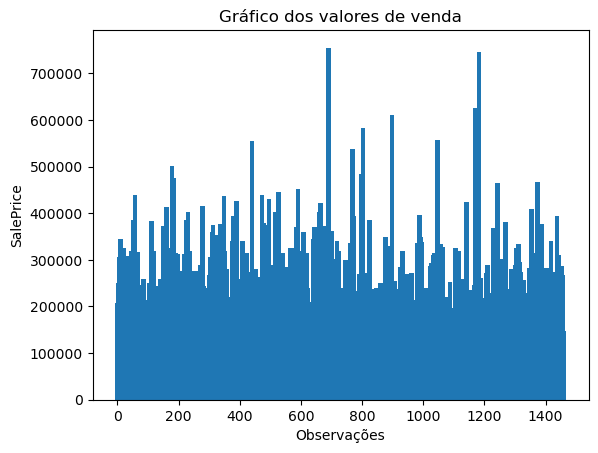

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


In [28]:
valores_venda = dados_brutos[dados_brutos["Origem"] == "Treino"]["SalePrice"]
#valores_venda = valores_venda.sort_values() # basta descomentar essa linha para gráfico com valores assimétricos
indice = dados_brutos[dados_brutos["Origem"] == "Treino"]["SalePrice"].index

plt.title("Gráfico dos valores de venda")
plt.xlabel("Observações")
plt.ylabel("SalePrice")
plt.bar(indice, valores_venda, width = 15)
plt.show()

print(dados_brutos[dados_brutos["Origem"] == "Treino"]["SalePrice"].describe())

### Modelagem com normalização Min-Max

In [29]:
# Normalizando os dados
minmax_scaler = MinMaxScaler()
x_minmax = minmax_scaler.fit_transform(treino_x)

# Normalizando o target
minmax_target_scaler = MinMaxScaler()
y_minmax = minmax_target_scaler.fit_transform(pd.DataFrame(treino_y))

# Normalizando os testes
minmax_scaler = MinMaxScaler()
x_teste_minmax = minmax_scaler.fit_transform(teste_x)

minmax_target_scaler = MinMaxScaler()
y_teste_minmax = minmax_target_scaler.fit_transform(pd.DataFrame(teste_y))

# Incluindo as dummies (não-normalizadas)
x_minmax = pd.concat([pd.DataFrame(x_minmax), treino_x_dummies], axis="columns")
x_minmax.columns = range(len(x_minmax.columns))

x_teste_minmax = pd.concat([pd.DataFrame(x_teste_minmax), teste_x_dummies], axis="columns")
x_teste_minmax.columns = range(len(x_teste_minmax.columns))

#####
## Treinando os modelos
#####

# Gradient Boost Regressor
minmax_gbr = GradientBoostingRegressor(random_state = 1).fit(x_minmax, y_minmax.ravel())
y_minmax_gbr = minmax_gbr.predict(x_teste_minmax)
y_pred_minmax_gbr = minmax_target_scaler.inverse_transform(y_minmax_gbr.reshape(-1, 1))

# Ridge
minmax_ridge = Ridge(alpha = 1.0).fit(x_minmax, y_minmax.ravel())
y_minmax_ridge = minmax_ridge.predict(x_teste_minmax)
y_pred_minmax_ridge = minmax_target_scaler.inverse_transform(y_minmax_ridge.reshape(-1, 1))

# Bayesian Ridge Regression
minmax_brr = linear_model.BayesianRidge().fit(x_minmax, y_minmax.ravel())
y_minmax_brr = minmax_brr.predict(x_teste_minmax)
y_pred_minmax_brr = minmax_target_scaler.inverse_transform(y_minmax_brr.reshape(-1, 1))

# Regressão Linear Simples (Linear Regression)
minmax_rl = LinearRegression().fit(x_minmax, y_minmax.ravel())
y_minmax_rl = minmax_rl.predict(x_teste_minmax)
y_pred_minmax_rl = minmax_target_scaler.inverse_transform(y_minmax_rl.reshape(-1, 1))

# Árvore de Decisão (decision tree)
minmax_tree = tree.DecisionTreeRegressor(random_state = 1).fit(x_minmax, y_minmax.ravel())
y_minmax_tree = minmax_tree.predict(x_teste_minmax)
y_pred_minmax_tree = minmax_target_scaler.inverse_transform(y_minmax_tree.reshape(-1, 1))

# (K Vizinhos Mais Próximos - KNN (K Nearest Neighbors))
minmax_knn = KNeighborsRegressor(n_neighbors = 2, weights = "uniform").fit(x_minmax, y_minmax.ravel())
y_minmax_knn = minmax_knn.predict(x_teste_minmax)
y_pred_minmax_knn_uniform = minmax_target_scaler.inverse_transform(y_minmax_knn.reshape(-1, 1))

minmax_knn = KNeighborsRegressor(n_neighbors = 2, weights = "distance").fit(x_minmax, y_minmax.ravel())
y_minmax_knn_d = minmax_knn.predict(x_teste_minmax)
y_pred_minmax_knn_distance = minmax_target_scaler.inverse_transform(y_minmax_knn_d.reshape(-1, 1))

### Modelagem com normalização Log

In [30]:
# Normalizando os dados
log_scaler = FunctionTransformer(np.log1p)
x_log = log_scaler.fit_transform(treino_x)

# Normalizando o target
log_target_scaler = FunctionTransformer(np.log1p)
y_log = log_target_scaler.fit_transform(pd.DataFrame(treino_y))

# Normalizando os testes
log_scaler = FunctionTransformer(np.log1p)
x_teste_log = log_scaler.fit_transform(teste_x)

log_target_scaler = FunctionTransformer(np.log1p)
y_teste_log = log_target_scaler.fit_transform(pd.DataFrame(teste_y))


# Incluindo as dummies (não-normalizadas)
x_log = pd.concat([pd.DataFrame(x_log), treino_x_dummies], axis="columns")
x_log.columns = range(len(x_log.columns))

x_teste_log = pd.concat([pd.DataFrame(x_teste_log), teste_x_dummies], axis="columns")
x_teste_log.columns = range(len(x_teste_log.columns))

#####
## Treinando os modelos
#####

# Gradient Boost Regressor
log_gbr = GradientBoostingRegressor(random_state = 1).fit(x_log, y_log)
y_log_gbr = log_gbr.predict(x_teste_log)
y_pred_log_gbr = np.expm1(y_log_gbr)

# Ridge
log_ridge = Ridge(alpha = 1.0).fit(x_log, y_log)
y_log_ridge = log_ridge.predict(x_teste_log)
y_pred_log_ridge = np.expm1(y_log_ridge)

# Bayesian Ridge Regression
log_brr = linear_model.BayesianRidge().fit(x_log, y_log)
y_log_brr = log_brr.predict(x_teste_log)
y_pred_log_brr = np.expm1(y_log_brr)

# Regressão Linear Simples (Linear Regression)
log_rl = LinearRegression().fit(x_log, y_log)
y_log_rl = log_rl.predict(x_teste_log)
y_pred_log_rl = np.expm1(y_log_rl)

# Árvore de Decisão (decision tree)
log_tree = tree.DecisionTreeRegressor(random_state = 1).fit(x_log, y_log)
y_log_tree = log_tree.predict(x_teste_log)
y_pred_log_tree = np.expm1(y_log_tree)

# (K Vizinhos Mais Próximos - KNN (K Nearest Neighbors))
log_knn = KNeighborsRegressor(n_neighbors = 2, weights = "uniform").fit(x_log, y_log)
y_log_knn = log_knn.predict(x_teste_log)
y_pred_log_knn_uniform = np.expm1(y_log_knn)

log_knn = KNeighborsRegressor(n_neighbors = 2, weights = "distance").fit(x_log, y_log)
y_log_knn_d = log_knn.predict(x_teste_log)
y_pred_log_knn_distance = np.expm1(y_log_knn_d)

/usr/lib/python3.12/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/usr/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### Modelagem com normalização Z-score

In [31]:
# Normalizando os dados
zscore_scaler = StandardScaler()
x_zscore = zscore_scaler.fit_transform(treino_x)

# Normalizando o target
zscore_target_scaler = StandardScaler()
y_zscore = zscore_target_scaler.fit_transform(pd.DataFrame(treino_y))

# Normalizando os testes
zscore_scaler = StandardScaler()
x_teste_zscore = zscore_scaler.fit_transform(teste_x)

zscore_target_scaler = StandardScaler()
y_teste_zscore = zscore_target_scaler.fit_transform(pd.DataFrame(teste_y))

# Incluindo as dummies (não-normalizadas)
x_zscore = pd.concat([pd.DataFrame(x_zscore), treino_x_dummies], axis="columns")
x_zscore.columns = range(len(x_log.columns))

x_teste_zscore = pd.concat([pd.DataFrame(x_teste_zscore), teste_x_dummies], axis="columns")
x_teste_zscore.columns = range(len(x_teste_zscore.columns))

#####
## Treinando os modelos
#####

# Gradient Boost Regressor
zscore_gbr = GradientBoostingRegressor(random_state = 1).fit(x_zscore, y_zscore)
y_zscore_gbr = zscore_gbr.predict(x_teste_zscore)
y_pred_zscore_gbr = zscore_target_scaler.inverse_transform(y_zscore_gbr.reshape(-1, 1))

# Ridge
zscore_ridge = Ridge(alpha = 1.0).fit(x_zscore, y_zscore)
y_zscore_ridge = zscore_ridge.predict(x_teste_zscore)
y_pred_zscore_ridge = zscore_target_scaler.inverse_transform(y_zscore_ridge.reshape(-1, 1))

# Bayesian Ridge Regression
zscore_brr = linear_model.BayesianRidge().fit(x_zscore, y_zscore)
y_zscore_brr = zscore_brr.predict(x_teste_zscore)
y_pred_zscore_brr = zscore_target_scaler.inverse_transform(y_zscore_brr.reshape(-1, 1))

# Regressão Linear Simples (Linear Regression)
zscore_rl = LinearRegression().fit(x_zscore, y_zscore)
y_zscore_rl = zscore_rl.predict(x_teste_zscore)
y_pred_zscore_rl = zscore_target_scaler.inverse_transform(y_zscore_rl.reshape(-1, 1))

# Árvore de Decisão (decision tree)
zscore_tree = tree.DecisionTreeRegressor(random_state = 1).fit(x_zscore, y_zscore)
y_zscore_tree = zscore_tree.predict(x_teste_zscore)
y_pred_zscore_tree = zscore_target_scaler.inverse_transform(y_zscore_tree.reshape(-1, 1))

# (K Vizinhos Mais Próximos - KNN (K Nearest Neighbors))
zscore_knn = KNeighborsRegressor(n_neighbors = 2, weights = "uniform").fit(x_zscore, y_zscore)
y_zscore_knn = zscore_knn.predict(x_teste_zscore)
y_pred_zscore_knn_uniform = zscore_target_scaler.inverse_transform(y_zscore_knn.reshape(-1, 1))

zscore_knn = KNeighborsRegressor(n_neighbors = 2, weights = "distance").fit(x_zscore, y_zscore)
y_zscore_knn_d = zscore_knn.predict(x_teste_zscore)
y_pred_zscore_knn_distance = zscore_target_scaler.inverse_transform(y_zscore_knn_d.reshape(-1, 1))

/usr/lib/python3.12/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
/usr/lib/python3.12/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


# Análise dos resultados
Realizada através de RMSE (root mean squared error), no caso deste desafio.

### Importação das bibliotecas adicionais necessárias

In [32]:
from sklearn.metrics import root_mean_squared_error

### Sem normalização

In [33]:
print("Linear Regression")
print(root_mean_squared_error(teste_y, y_rl))
print("\nDecision Tree")
print(root_mean_squared_error(teste_y, y_tree))
print("\nKNN (uniform)")
print(root_mean_squared_error(teste_y, y_knn_uniform))
print("\nKNN (distance)")
print(root_mean_squared_error(teste_y, y_knn_distance))
print("\nGBR")
print(root_mean_squared_error(teste_y, y_gbr))
print("\nRidge")
print(root_mean_squared_error(teste_y, y_ridge))
print("\nBayesian Ridge")
print(root_mean_squared_error(teste_y, y_brr))

Linear Regression
30559.57135274195

Decision Tree
34970.65547960729

KNN (uniform)
48501.438175166266

KNN (distance)
49141.15194964844

GBR
23070.694059978698

Ridge
30233.440909420013

Bayesian Ridge
29259.50049038501


### Com normalização MinMax

In [34]:
print("Linear Regression")
print(root_mean_squared_error(teste_y, y_pred_minmax_rl))
print("\nDecision Tree")
print(root_mean_squared_error(teste_y, y_pred_minmax_tree))
print("\nKNN (uniform)")
print(root_mean_squared_error(teste_y, y_pred_minmax_knn_uniform))
print("\nKNN (distance)")
print(root_mean_squared_error(teste_y, y_pred_minmax_knn_distance))
print("\nGBR")
print(root_mean_squared_error(teste_y, y_pred_minmax_gbr))
print("\nRidge")
print(root_mean_squared_error(teste_y, y_pred_minmax_ridge))
print("\nBayesian Ridge")
print(root_mean_squared_error(teste_y, y_pred_minmax_brr))

Linear Regression
1.0088888535169331e+17

Decision Tree
35753.24534931819

KNN (uniform)
90160.96677177127

KNN (distance)
94975.86855172628

GBR
29538.434801705633

Ridge (menor observação aqui)
44609.433461921755

Bayesian Ridge
42627.67107212412


### Z-Score

In [35]:
print("Linear Regression")
print(root_mean_squared_error(teste_y, y_pred_zscore_rl))
print("\nDecision Tree")
print(root_mean_squared_error(teste_y, y_pred_zscore_tree))
print("\nKNN (uniform)")
print(root_mean_squared_error(teste_y, y_pred_zscore_knn_uniform))
print("\nKNN (distance)")
print(root_mean_squared_error(teste_y, y_pred_zscore_knn_distance))
print("\nGBR")
print(root_mean_squared_error(teste_y, y_pred_zscore_gbr))
print("\nRidge")
print(root_mean_squared_error(teste_y, y_pred_zscore_ridge))
print("\nBayesian Ridge")
print(root_mean_squared_error(teste_y, y_pred_zscore_brr))

Linear Regression (teve algum erro aqui, verificar)
479244350581174.1

Decision Tree
36540.74166694272

KNN (uniform)
43025.70608958793

KNN (distance)
43056.13395747017

GBR
22802.00431839212

Ridge
29981.614299417324

Bayesian Ridge
29352.088597998456


### Log

In [36]:
print("Linear Regression")
try: print(root_mean_squared_error(teste_y, y_pred_log_rl))
except: print("Erro no resultado da Regressão Linear")
print("\nDecision Tree")
print(root_mean_squared_error(teste_y, y_pred_log_tree))
print("\nKNN (uniform)")
print(root_mean_squared_error(teste_y, y_pred_log_knn_uniform))
print("\nKNN (distance)")
print(root_mean_squared_error(teste_y, y_pred_log_knn_distance))
print("\nGBR")
print(root_mean_squared_error(teste_y, y_pred_log_gbr))
print("\nRidge")
print(root_mean_squared_error(teste_y, y_pred_log_ridge))
print("\nBayesian Ridge")
print(root_mean_squared_error(teste_y, y_pred_log_brr))

Linear Regression
24981.610187822025

Decision Tree
37140.71167739285

KNN (uniform)
56383.03480272194

KNN (distance)
57041.89800109755

GBR
23930.435819131555

Ridge - Menor valor, com as Dummies
24551.457040955676

Bayesian Ridge
24604.992396156962


# Procedimentos de publicação

## Previsões baseada nos modelos desenvolvidos

Cada base de dados (normalizados/não-normalizado) teve uma breve diferença de resultados entre os melhores colocados de cada modelagem. Aqui serão gerados arquivos para submissão com o melhor de cada categoria bem como um stacked com a média das melhores previsões.

### Dados de teste e dummies

In [37]:
quali_final = variaveis_quali_backup[variaveis_quali_backup["Origem"] == "Teste"]
quali_final.reset_index(inplace = True)
quali_final = quali_final.drop(["Origem", "index"], axis = 1)

quanti_final = variaveis_quanti_teste[variaveis_quali_backup["Origem"] == "Teste"]
quanti_final.reset_index(inplace = True)
quanti_final = quanti_final.drop(["Origem", "index", "SalePrice"], axis = 1)

quali_temp = variaveis_quali_backup.drop("Origem", axis = 1)
dummies_temp = pd.get_dummies(quali_temp)
dummies_temp["Origem"] = variaveis_quali_backup["Origem"]
dummies_final = dummies_temp[dummies_temp["Origem"] == "Teste"]
dummies_final.reset_index(inplace = True)
dummies_final = dummies_final.drop(["Origem", "index"], axis = 1)
colunas_invalidas = list(dummies_final.columns[dummies_final.columns.isin(quali_dummies.columns) == False])
dummies_final = dummies_final.drop(colunas_invalidas, axis = 1)

/tmp/ipykernel_145924/2358745574.py:10: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  dummies_temp = pd.get_dummies(quali_temp)
/tmp/ipykernel_145924/2358745574.py:10: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  dummies_temp = pd.get_dummies(quali_temp)
/tmp/ipykernel_145924/2358745574.py:10: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  dummies_temp = pd.get_dummies(quali_temp)


### Modelo sem normalização

In [63]:
# Incluindo as dummies (não-normalizadas)
final_sn = pd.concat([quanti_final, dummies_final], axis="columns")
final_sn.columns = range(len(final_sn.columns))

# Realizando a previsão (buscar lá na modelagem)
y_sn_sub = sn_gbr.predict(final_sn)

### Modelo com normalização MinMax

In [59]:
# Normalizando os dados todos
minmax_scaler = MinMaxScaler()
#y_minmax = minmax_scaler.fit_transform(pd.DataFrame(dados_polidos_y)) #só é necessário se for refazer o modelo com a totalidade das informações
x_final_minmax = minmax_scaler.fit_transform(quanti_final)

# Incluindo as dummies (não-normalizadas)
final_minmax = pd.concat([pd.DataFrame(x_final_minmax), dummies_final], axis="columns")
final_minmax.columns = range(len(final_minmax.columns))

# Realizando a previsão (buscar lá na modelagem)
y_final_minmax = minmax_gbr.predict(final_minmax)
y_minmax_sub = minmax_target_scaler.inverse_transform(y_final_minmax.reshape(-1, 1))


### Modelo com normalização Z-Score

In [60]:
# Normalizando os dados
zscore_scaler = StandardScaler()
x_final_zscore = zscore_scaler.fit_transform(quanti_final)

# Incluindo as dummies (não-normalizadas)
x_final_zscore = pd.concat([pd.DataFrame(x_final_zscore), dummies_final], axis="columns")
x_final_zscore.columns = range(len(x_final_zscore.columns))

# Realizando a previsão (buscar lá na modelagem)
y_zscore_gbr = zscore_gbr.predict(x_final_zscore)
y_zscore_sub = zscore_target_scaler.inverse_transform(y_zscore_gbr.reshape(-1, 1))

### Modelo com normalização Log

In [61]:
# Normalizando os dados
log_scaler = FunctionTransformer(np.log1p)
x_final_log = log_scaler.fit_transform(quanti_final)
x_final_log.reset_index(inplace = True)
x_final_log = x_final_log.drop("index", axis = 1)

# Incluindo as dummies (não-normalizadas)
x_final_log = pd.concat([pd.DataFrame(x_final_log), dummies_final], axis="columns")
x_final_log.columns = range(len(x_final_log.columns))

# Realizando a previsão (buscar lá na modelagem)
y_log_modelo_final = log_gbr.predict(x_final_log)
y_log_sub = np.expm1(y_log_modelo_final)

## Gerando arquivos de submissão

In [ ]:
# Sem Normalização
submissao_sn = pd.read_csv("test.csv")
submissao_sn["SalePrice"] = y_sn_sub
resultado_sn = submissao_sn[["Id", "SalePrice"]]
#resultado_sn.to_csv("resultado_sem_normalizacao.csv", index=False)
#resultado_sn.to_csv("resultado_sem_normalizacao_dummies.csv", index=False)
#resultado_sn.to_csv("resultado_sem_norm_dummies_outLotFrontage.csv", index=False)
#resultado_sn.to_csv("resultado_sem_norm_dummies_outSalePrice.csv", index=False)
resultado_sn.to_csv("resultado_sn_outLotFrontage_TerrenoLivre.csv", index=False)

# Com Normalização MinMax
submissao_minmax = pd.read_csv("test.csv")
submissao_minmax["SalePrice"] = y_minmax_sub
resultado_minmax = submissao_minmax[["Id", "SalePrice"]]
#resultado_minmax.to_csv("resultado_norm_minmax.csv", index=False)
#resultado_minmax.to_csv("resultado_norm_minmax_dummies.csv", index=False)
resultado_minmax.to_csv("resultado_minmax_outLotFrontage_TerrenoLivre.csv", index=False)


# Com Normalização Z-Score
submissao_zscore = pd.read_csv("test.csv")
submissao_zscore["SalePrice"] = y_zscore_sub
resultado_zscore = submissao_zscore[["Id", "SalePrice"]]
#resultado_zscore.to_csv("resultado_norm_zscore.csv", index=False)
#resultado_zscore.to_csv("resultado_norm_zscore_dummies.csv", index=False)
#resultado_zscore.to_csv("resultado_norm_zscore_dummies_outLotFrontage.csv", index=False)
#resultado_zscore.to_csv("resultado_norm_zscore_dummies_outSalePrice.csv", index=False)
resultado_zscore.to_csv("resultado_zscore_outLotFrontage_TerrenoLivre.csv", index=False)

# Com Normalização Log
submissao_log = pd.read_csv("test.csv")
submissao_log["SalePrice"] = y_log_sub
resultado_log = submissao_log[["Id", "SalePrice"]]
#resultado_log.to_csv("resultado_norm_log.csv", index=False)
#resultado_log.to_csv("resultado_norm_log_dummies.csv", index=False)
#resultado_log.to_csv("resultado_norm_log_dummies_outLotFrontage.csv", index=False)
#resultado_log.to_csv("resultado_norm_log_dummies_outSalePrice.csv", index=False)
resultado_log.to_csv("resultado_log_outLotFrontage_TerrenoLivre.csv", index=False)

# Stacked Normalizações
submissao_stacked_norm = pd.read_csv("test.csv")

stacked_media = pd.DataFrame(y_sn_sub)
stacked_media = stacked_media + pd.DataFrame(y_minmax_sub)
stacked_media = stacked_media + pd.DataFrame(y_zscore_sub)
stacked_media = stacked_media + pd.DataFrame(y_log_sub)
stacked_media = stacked_media/4

submissao_stacked_norm["SalePrice"] = stacked_media
resultado_stacked_norm = submissao_stacked_norm[["Id", "SalePrice"]]
resultado_stacked_norm.to_csv("resultado_stacked_outLotFrontage_TerrenoLivre.csv", index=False)

## Resultados

#### Sem tratamento apropriado dos dados - min 0.14162

Pontuação 'crua' 0.14569 (quanto menor, melhor)

Pontuação y_log_final 0.14162

#### (22/05) Normalização, sem variáveis quali - min 0.14159

Pontuação Normalização LOG 0.14337

Pontuação Normalização MinMax 0.60592

Pontuação Normalização Z-Score 0.15056

Pontuação Sem Normalização 0.14783

Pontuação Stacked (com MinMax) 0.14159

Pontuação Stacked (sem MinMax) 0.14380

#### (23/05) Normalização, com variáveis quali - min 0.12760

Pontuação Normalização LOG com dummies 0.12872

Pontuação Normalização MinMax com dummies 0.62852

Pontuação Normalização Z-Score com dummies 0.14158

Pontuação Sem Normalização com dummies 0.13726

Pontuação Stacked (com MinMax) com dummies 0.13253

Pontuação Stacked (sem MinMax) com dummies 0.12760

#### (24/05) Normalização, dummies, outliers filtrados - min 0.14532 (log)

    Outliers retirados de LotFrontage e TerrenoLivre

Pontuação Normalização LOG 0.14532

Pontuação Normalização MinMax 0.20137

Pontuação Normalização Z-Score 0.15770

Pontuação Sem Normalização 0.15057

Pontuação Stacked (com MinMax) 0.15408